# **Importacion de paquetes**
---

In [1]:
import pandas as pd
import gender_guesser.detector as gender
from wordcloud import WordCloud
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk
from deepface import DeepFace
from textblob import TextBlob
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import seaborn as sns
import matplotlib.pyplot as plt

2024-07-04 00:51:55.630740: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# **Carga de datos**
---

In [2]:
data=pd.read_csv('../../../Dataset_Review/Raw/CommentDataset_v2.csv').iloc[:,1:]
print('Tamaño: ',data.shape)
data.head()

Tamaño:  (17711, 7)


,name,imagen,user_id,valoracion,comentario,apart_id,ubicacion
0,Barbara Diaz,https://a0.muscache.com/im/pictures/user/e97d0...,-5345305016665044310,Valoración: 3 estrellas,"Absolutamente bien lugar. Camas duras, y lejos...",https://www.airbnb.es/rooms/46527977?adults=1&...,Lleva 6 años en Airbnb
1,Txema,https://a0.muscache.com/im/pictures/user/0c5a3...,7554217637905518485,Valoración: 4 estrellas,"Buenas gestión y atención , volveré a usar es...",https://www.airbnb.es/rooms/46527977?adults=1&...,Lleva 8 años en Airbnb
2,Aloe,https://a0.muscache.com/im/pictures/user/4df2c...,2753252670262692822,Valoración: 1 estrella,Para empezar en los mundos que corre que te co...,https://www.airbnb.es/rooms/46527977?adults=1&...,Lleva 9 años en Airbnb
3,Nichola,https://a0.muscache.com/im/pictures/user/b8437...,5933799744255950932,Valoración: 5 estrellas,Situado en la mejor zona de Benidorm. con vist...,https://www.airbnb.es/rooms/46527977?adults=1&...,Lleva 6 años en Airbnb
4,Elena,https://a0.muscache.com/im/pictures/user/b8f5e...,3658483447196535546,Valoración: 5 estrellas,Pasamos una estancia muy agradable. Nos ha gus...,https://www.airbnb.es/rooms/46527977?adults=1&...,Lleva 6 años en Airbnb


### **Información general**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17711 entries, 0 to 17710
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        17711 non-null  object
 1   imagen      17711 non-null  object
 2   user_id     17711 non-null  int64 
 3   valoracion  17711 non-null  object
 4   comentario  17530 non-null  object
 5   apart_id    17711 non-null  object
 6   ubicacion   17711 non-null  object
dtypes: int64(1), object(6)
memory usage: 968.7+ KB


In [4]:
data.isna().sum()

name            0
imagen          0
user_id         0
valoracion      0
comentario    181
apart_id        0
ubicacion       0
dtype: int64

hay que eliminar estos datos porque sin el comentario no hay analisis.

In [5]:
data.dropna(inplace=True)

# **Extracción genero**
---

In [6]:
d = gender.Detector(case_sensitive=False)
def solo_un_nombre(name):
    partes = name.split()
    if len(partes) > 1:
        return partes[0]
    else:
        return name

data['first_name'] = data['name'].apply(solo_un_nombre)
data['gender'] = data['first_name'].apply(d.get_gender)

data.loc[data['name'].str.contains('|'.join(['Javier', 'Jesus', 'Jesús', 'João','Txema'])), 'gender'] = 'male'
data.loc[data['name'].str.contains('|'.join(['Glória', 'Mary', 'Rocío', 'Lupe','Carol', 'Luz', 'Mary Paule', 'Leslie','María'])), 'gender'] = 'female'
data['gender']=data['gender'].str.replace('mostly_female','female').str.replace('mostly_male','male').str.replace('andy','unknown')

# **Extracción de la valoración**
---

In [7]:
def extraer_numeros(texto):
    numeros = re.findall(r'\d+', texto)
    if numeros:
        return int(numeros[0])
    else:
        return None

data['rating'] = data['valoracion'].apply(extraer_numeros)
data.drop('valoracion', axis=1, inplace=True)

# **Extracción de la edad**
---

In [45]:
def analyze_image(image_path):
    try:
        result = DeepFace.analyze(image_path)
        edad = result[0]['age']
        genero = result[0]['dominant_gender']
    except:
        edad = None
        genero = None
    return edad, genero

data[['edad', 'genero']] = data['imagen'].apply(lambda x: pd.Series(analyze_image(x)))

Action: emotion:   0%|          | 0/4 [00:00<?, ?it/s]

24-07-03 21:45:02 - facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /Users/mariolamas/.deepface/weights/facial_expression_model_weights.h5
100%|██████████| 5.98M/5.98M [00:00<00:00, 14.8MB/s]


In [ ]:
data['edad'].isna().sum()

17711

Debido a las imagenes no consigue extraer información.

# **Analysis y Tokens**
---

In [10]:

tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment", force_download=True)
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment", force_download=True)

def calcular_puntaje_sentimiento(df):
    analysis = []
    token=[]
    for comentario in df['comentario']:
        if isinstance(comentario, str):
            # Truncar el comentario si es demasiado largo
            comentario_truncado = comentario[:512]
            tokens = tokenizer.encode(comentario_truncado, return_tensors='pt', max_length=512, truncation=True)
            result = model(tokens)
            score = torch.argmax(result.logits).item() + 1
            analysis.append(score)
            token.append(tokens)
        else:
            analysis.append(None)  # Otra opción es asignar algún valor para comentarios que no sean cadenas de texto
    df['analysis'] = analysis
    df['tokens'] = token

calcular_puntaje_sentimiento(data)

KeyboardInterrupt: 

# **Sentimiento**
---

In [8]:
# Función para calcular el sentimiento
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Añadir columna de sentimiento
data['sentimiento'] = data['comentario'].astype(str).apply(get_sentiment)

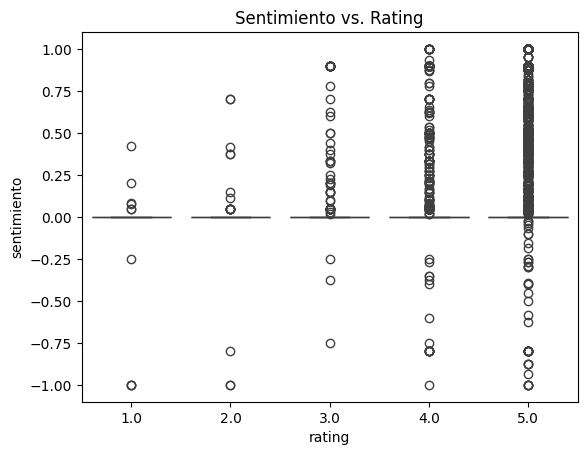

In [9]:

sns.boxplot(x='rating', y='sentimiento', data=data)
plt.title('Sentimiento vs. Rating')
plt.show()

# **Contiene pregunta**
---

In [21]:
data['pregunta']=data['comentario'].apply(lambda x: True if ('?' in x) or ('¿' in x) else False)

In [23]:
data['pregunta'].value_counts() /len(data)

pregunta
False    0.996863
True     0.003137
Name: count, dtype: float64

# **Promedio longitud palabras**
---

In [36]:
sum(len(word) for word in TextBlob(data['comentario'].values[0]).words) / len(TextBlob(data['comentario'].values[0]).words)

4.8059701492537314

In [29]:
def prom_long(x):
    return sum(len(word) for word in TextBlob(x).words) / len(TextBlob(x).words)
data['prom_long_word']=data['comentario'].apply(lambda x: prom_long(x))

# **Num de adjetivos**
---

In [30]:
def num_adj(x):
    return sum(1 for word, tag in zip(TextBlob(x).words,TextBlob(x).tags) if tag[1]=='JJ')
data['num_adj'] = data['comentario'].apply(num_adj)

# **Eliminamos stopwords y sacamos tokens**
---

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mariolamas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


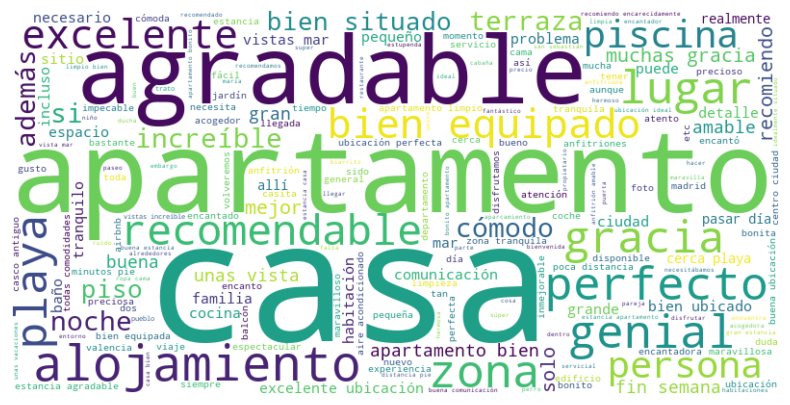

In [31]:
# Preprocesamiento del texto
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

data['text_clean'] = data['comentario'].astype(str).apply(preprocess_text)
data['tokens'] = data['text_clean'].apply(nltk.word_tokenize)
data['tokens'] = data['tokens'].apply(lambda x: [word for word in x if word not in stop_words])
data['text_clean'] = data['tokens'].apply(lambda x: ' '.join(x))

# Generar la nube de palabras
all_words = ' '.join([text for text in data['text_clean']])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
print(wordcloud)
# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# **Carga datos apartamentos**
---

In [32]:
aparts=pd.read_csv('../../limpieza/aparts/DatasetAirbnb_Cleaned_v1.csv')

# **Correlacion entre sentimiento y evaluaciones**
---

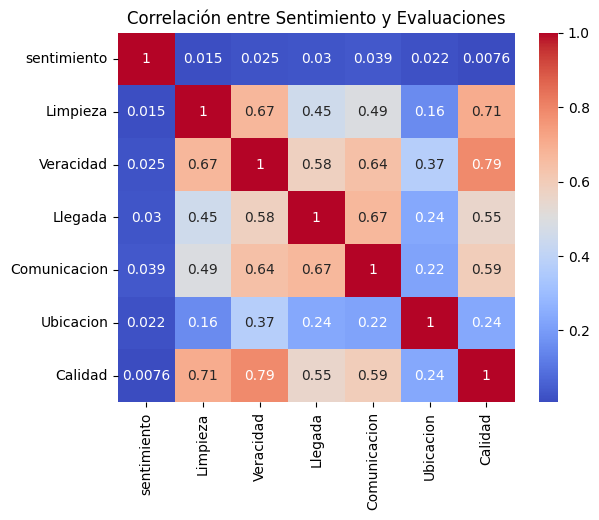

In [33]:
df_merged = pd.merge(aparts, data, left_on='URL',right_on='apart_id')
# Calcular la correlación
correlation_matrix = df_merged[['sentimiento', 'Limpieza', 'Veracidad', 'Llegada', 'Comunicacion', 'Ubicacion', 'Calidad']].corr()

# Mostrar la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlación entre Sentimiento y Evaluaciones')
plt.show()

# **Relación comentarios-Precio**
---

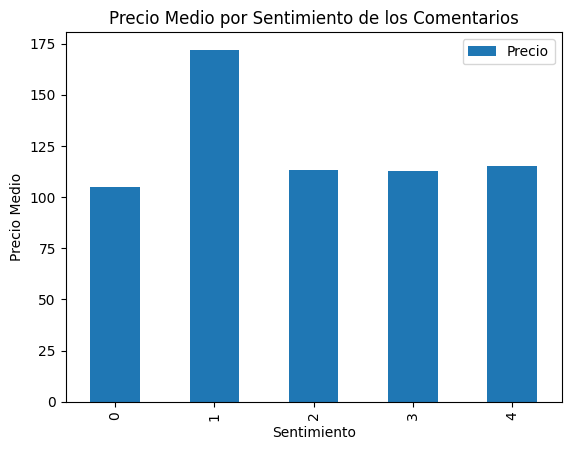

In [34]:
# Calcular el precio medio por sentimiento
precio_sentimiento = df_merged.groupby(pd.cut(df_merged['sentimiento'], bins=5))['Precio'].mean().reset_index()

precio_sentimiento['Precio']=np.exp(precio_sentimiento['Precio'])
# Mostrar el precio medio por sentimiento

# Graficar el precio medio por sentimiento
precio_sentimiento.plot(kind='bar')
plt.title('Precio Medio por Sentimiento de los Comentarios')
plt.xlabel('Sentimiento')
plt.ylabel('Precio Medio')
plt.show()

# **Quejas comunes**
---

ubicación    3699
limpieza      567
ruido         428
wifi          233
baños         218
parking       106
dtype: int64


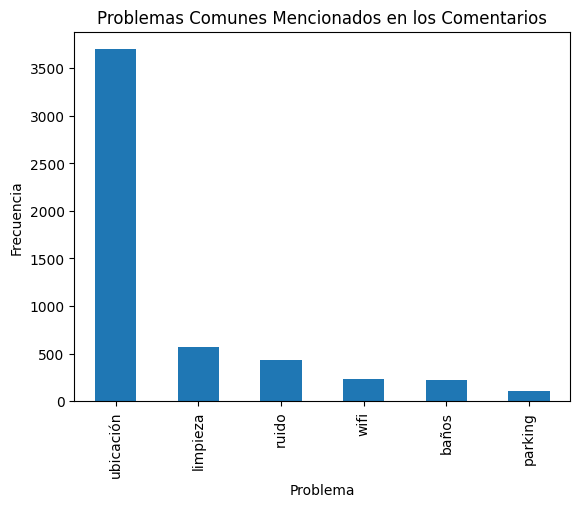

In [35]:
# Crear una lista de problemas comunes a buscar en los comentarios
problemas_comunes = ['ruido', 'limpieza', 'ubicación', 'wifi', 'parking', 'baños']

# Crear una función para contar la aparición de cada problema en los comentarios
def contar_problemas(text, problemas):
    contador = {problema: text.count(problema) for problema in problemas}
    return contador

# Aplicar la función a los comentarios
data['problemas'] = data['text_clean'].apply(lambda x: contar_problemas(x, problemas_comunes))

# Convertir la columna de problemas a un DataFrame separado
problemas_df = data['problemas'].apply(pd.Series).sum().sort_values(ascending=False)
print(problemas_df)

# Graficar los problemas más comunes
problemas_df.plot(kind='bar')
plt.title('Problemas Comunes Mencionados en los Comentarios')
plt.xlabel('Problema')
plt.ylabel('Frecuencia')
plt.show()


In [43]:
df_merged['Precio']=np.exp(df_merged['Precio'])

<Axes: xlabel='prom_long_word', ylabel='Capacidad'>

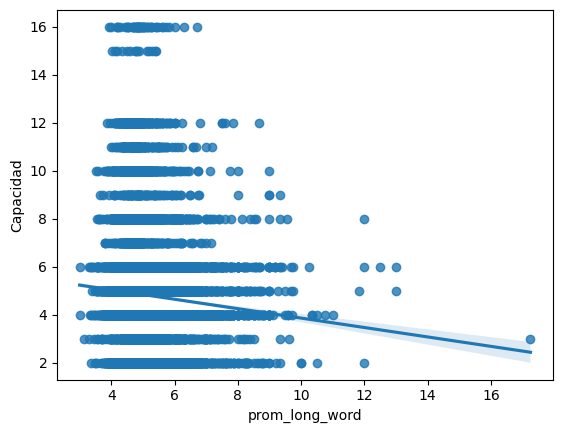

In [46]:
sns.regplot(x='prom_long_word', y='Capacidad', data=df_merged)

<Axes: xlabel='num_adj', ylabel='Capacidad'>

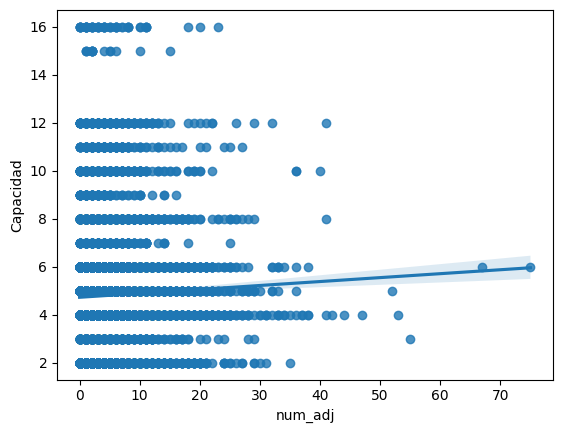

In [47]:
sns.regplot(x='num_adj', y='Capacidad', data=df_merged)

In [40]:
df_merged.groupby('Tipo')[['prom_long_word','num_adj']].median().reset_index()


,Tipo,prom_long_word,num_adj
0,0.0,5.100000,3.0
1,2.0,4.888889,3.0
